In [1]:
import sys
sys.path.append("../../../")

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from model.losses import *
from model.bpho.multi import *
from model.bpho.resnet import *
from model.bpho.unet import *
from model.metrics import psnr, ssim
from data.load_fluo import *

In [3]:
from scipy.ndimage.interpolation import zoom as npzoom

In [4]:
torch.cuda.set_device(2)

# Model loading

### load data

In [5]:
bs = 8  # batch size
size = 768  # image size
tile_sz=512 
lr_type = 't'
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/')
model_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/feat_loss')
if lr_type == 's':
    z_frames, t_frames = 1, 1
    n_frames = 1
    dataset = data_pth/'mitotracker_PSSR-SF'
    hr_tifs = dataset/f'hr'
    lr_tifs = dataset/f'lr'
elif lr_type == 't':
    z_frames, t_frames = 1, 5
    n_frames = 5
    multi_str = f'_{lr_type}_{n_frames}'
    tile_sz = 512
    dataset = data_pth/'mitotracker_PSSR-MF'
    hr_tifs = dataset/f'hr_t_{tile_sz:d}{multi_str}'
    lr_tifs = dataset/f'lr_t_{tile_sz:d}{multi_str}'

In [6]:
mode = 'L'
norm = True
noise = False
cutout = False # Maybe?

In [7]:
data = get_data(bs, size, lr_tifs, hr_tifs, n_frames=n_frames,  max_zoom=4., 
                    use_cutout=cutout, use_noise=noise, mode=mode, norm=norm)

normalizing x and y data


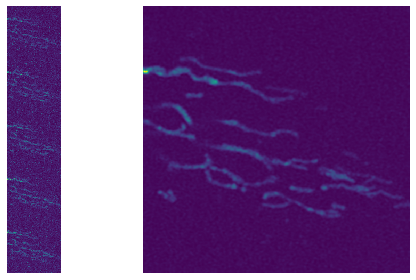

In [8]:
data.show_batch(rows=1)

### initiate learner

In [9]:
wnres_args = {
    'blur': True,
    'blur_final': True,
    'bottle': True,
    'self_attention': True,
    'last_cross': True
    
}
arch = 'wnresnet34'
wd = 1e-3
arch = eval(arch)
metrics = [psnr, ssim]

In [10]:
learn = wnres_unet_learner(data, arch, in_c=n_frames, wnres_args=wnres_args,
                         metrics=metrics,
                           model_dir=model_pth, callback_fns=[LossMetrics], wd=wd)

In [11]:
learn.model_dir

PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/feat_loss')

# infer real_world data

In [173]:
test_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/LR')
test_data_name = 'real-world_mitotracker'
test_set = MultiImageImageList.from_folder(test_pth/test_data_name/'npy', extensions=['.npy'])
learn.data.add_test(test_set, tfm_y=False)

In [175]:
def model_inference(learner, model_name="changeme"):
    parent_name = 'MF_'+model_name
    dir_name = test_pth.parent/parent_name/test_data_name
    if not os.path.isdir(dir_name): dir_name.mkdir(parents=True, exist_ok=True)
    for img, img_name in zip(learner.data.test_ds, learner.data.test_ds.items):
        pred, _, _ = learner.predict(img[0])
        pred_name = str(img_name.parent).replace('LR', parent_name).replace('npy', '')+img_name.stem+'.tif'
        pred.save(pred_name)
        print(f"Performed inference on {img_name.stem}, file saved as {pred_name}")
    print("Model Inference Complete")

In [176]:
for model_name in ["fluo_inpainting_100epoch",
                   "fluo_inpainting_new_100epoch",
                   "fluo_sf_100epoch"]:
    learn = learn.load(file=model_name)
    learn.data.add_test(test_set, tfm_y=False)
    model_inference(learner=learn, model_name=model_name)

Performed inference on mitotracker_video_01_LR_8bit_290, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_290.tif
Performed inference on mitotracker_video_01_LR_8bit_285, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_285.tif
Performed inference on mitotracker_video_01_LR_8bit_171, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_171.tif
Performed inference on mitotracker_video_01_LR_8bit_192, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_192.tif
Performed inference on mitotracker_video_01_LR_8bit_288, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker

Performed inference on mitotracker_video_01_LR_8bit_124, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_124.tif
Performed inference on mitotracker_video_01_LR_8bit_244, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_244.tif
Performed inference on mitotracker_video_01_LR_8bit_295, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_295.tif
Performed inference on mitotracker_video_01_LR_8bit_154, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_154.tif
Performed inference on mitotracker_video_01_LR_8bit_121, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker

Performed inference on mitotracker_video_01_LR_8bit_119, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_119.tif
Performed inference on mitotracker_video_01_LR_8bit_172, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_172.tif
Performed inference on mitotracker_video_01_LR_8bit_11, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_11.tif
Performed inference on mitotracker_video_01_LR_8bit_211, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_211.tif
Performed inference on mitotracker_video_01_LR_8bit_18, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_vi

Performed inference on mitotracker_video_01_LR_8bit_24, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_24.tif
Performed inference on mitotracker_video_01_LR_8bit_176, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_176.tif
Performed inference on mitotracker_video_01_LR_8bit_110, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_110.tif
Performed inference on mitotracker_video_01_LR_8bit_233, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_233.tif
Performed inference on mitotracker_video_01_LR_8bit_236, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_v

Performed inference on mitotracker_video_01_LR_8bit_164, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_164.tif
Performed inference on mitotracker_video_01_LR_8bit_25, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_25.tif
Performed inference on mitotracker_video_01_LR_8bit_203, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_203.tif
Performed inference on mitotracker_video_01_LR_8bit_161, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_161.tif
Performed inference on mitotracker_video_01_LR_8bit_17, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_vi

Performed inference on mitotracker_video_01_LR_8bit_200, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_200.tif
Performed inference on mitotracker_video_01_LR_8bit_226, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_226.tif
Performed inference on mitotracker_video_01_LR_8bit_87, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_87.tif
Performed inference on mitotracker_video_01_LR_8bit_177, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_177.tif
Performed inference on mitotracker_video_01_LR_8bit_248, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_v

Performed inference on mitotracker_video_01_LR_8bit_141, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_141.tif
Performed inference on mitotracker_video_01_LR_8bit_100, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_100.tif
Performed inference on mitotracker_video_01_LR_8bit_19, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_19.tif
Performed inference on mitotracker_video_01_LR_8bit_219, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_219.tif
Performed inference on mitotracker_video_01_LR_8bit_107, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_v

Performed inference on mitotracker_video_01_LR_8bit_61, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_61.tif
Performed inference on mitotracker_video_01_LR_8bit_158, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_158.tif
Performed inference on mitotracker_video_01_LR_8bit_149, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_149.tif
Performed inference on mitotracker_video_01_LR_8bit_80, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_80.tif
Performed inference on mitotracker_video_01_LR_8bit_213, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_100epoch/mitotracker_vid

Performed inference on mitotracker_video_01_LR_8bit_175, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_175.tif
Performed inference on mitotracker_video_01_LR_8bit_238, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_238.tif
Performed inference on mitotracker_video_01_LR_8bit_75, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_75.tif
Performed inference on mitotracker_video_01_LR_8bit_112, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_112.tif
Performed inference on mitotracker_video_01_LR_8bit_34, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100

Performed inference on mitotracker_video_01_LR_8bit_12, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_12.tif
Performed inference on mitotracker_video_01_LR_8bit_123, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_123.tif
Performed inference on mitotracker_video_01_LR_8bit_92, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_92.tif
Performed inference on mitotracker_video_01_LR_8bit_130, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_130.tif
Performed inference on mitotracker_video_01_LR_8bit_155, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100e

Performed inference on mitotracker_video_01_LR_8bit_289, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_289.tif
Performed inference on mitotracker_video_01_LR_8bit_53, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_53.tif
Performed inference on mitotracker_video_01_LR_8bit_153, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_153.tif
Performed inference on mitotracker_video_01_LR_8bit_222, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_222.tif
Performed inference on mitotracker_video_01_LR_8bit_122, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_10

Performed inference on mitotracker_video_01_LR_8bit_33, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_33.tif
Performed inference on mitotracker_video_01_LR_8bit_96, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_96.tif
Performed inference on mitotracker_video_01_LR_8bit_7, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_7.tif
Performed inference on mitotracker_video_01_LR_8bit_272, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_272.tif
Performed inference on mitotracker_video_01_LR_8bit_212, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch

Performed inference on mitotracker_video_01_LR_8bit_59, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_59.tif
Performed inference on mitotracker_video_01_LR_8bit_55, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_55.tif
Performed inference on mitotracker_video_01_LR_8bit_246, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_246.tif
Performed inference on mitotracker_video_01_LR_8bit_20, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_20.tif
Performed inference on mitotracker_video_01_LR_8bit_138, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epo

Performed inference on mitotracker_video_01_LR_8bit_143, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_143.tif
Performed inference on mitotracker_video_01_LR_8bit_117, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_117.tif
Performed inference on mitotracker_video_01_LR_8bit_139, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_139.tif
Performed inference on mitotracker_video_01_LR_8bit_187, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_100epoch/mitotracker_videos/mitotracker_video_01_LR_8bit_187.tif
Performed inference on mitotracker_video_01_LR_8bit_148, file saved as /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/MF_fluo_inpainting_new_

KeyboardInterrupt: 

# infer movies

### npy

In [19]:
from libtiff import TIFF

In [20]:
import imageio

In [13]:
tif_dirname = Path("/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/LR/semi-synth_mitotracker")

In [14]:
tif_list = list(tif_dirname.glob('*.tif'))

In [15]:
tif_list

[PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/LR/semi-synth_mitotracker/semisynth_5_LR.tif'),
 PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/LR/semi-synth_mitotracker/semisynth_6_LR.tif'),
 PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/LR/semi-synth_mitotracker/semisynth_3_LR.tif'),
 PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/LR/semi-synth_mitotracker/semisynth_1_LR.tif'),
 PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/LR/semi-synth_mitotracker/semisynth_4_LR.tif'),
 PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/LR/semi-synth_mitotracker/semisynth_2_LR.tif')]

In [16]:
tif_in = tif_list[0]
im = PIL.Image.open(tif_in)
times = im.n_frames

In [35]:
list(TIFF.open(tif_in).iter_images())[0].shape

(192, 192)

In [42]:
img=PIL.Image.open(tif_in)

In [44]:
img.size

(192, 192)

In [53]:
for tif_fname in tif_list:
    tif = TIFF.open(tif_fname)
    img = PIL.Image.open(tif_fname)
    img_size = img.size[0]
    img_stack = np.zeros((times, img_size, img_size), dtype=np.uint8)
    for i, img in enumerate(tif.iter_images()):
        img_stack[i] = img
    for i in range(times-4):
        five_stack = np.zeros((5, img_size, img_size), dtype=np.uint8)
        five_stack = img_stack[i:i+5]
        npy_dirname = tif_fname.parent/'npy'/str(img_size)
        if not os.path.isdir(npy_dirname): npy_dirname.mkdir(parents=True, exist_ok=True)
        npy_fname = npy_dirname/(tif_fname.stem+f'_{i}.npy')
        np.save(npy_fname, five_stack)

(192, 192) 0
(192, 192) 1
(192, 192) 2
(192, 192) 3
(192, 192) 4
(192, 192) 5
(192, 192) 6
(192, 192) 7
(192, 192) 8
(192, 192) 9
(192, 192) 10
(192, 192) 11
(192, 192) 12
(192, 192) 13
(192, 192) 14
(192, 192) 15
(192, 192) 16
(192, 192) 17
(192, 192) 18
(192, 192) 19
(192, 192) 20
(192, 192) 21
(192, 192) 22
(192, 192) 23
(192, 192) 24
(192, 192) 25
(192, 192) 26
(192, 192) 27
(192, 192) 28
(192, 192) 29
(192, 192) 30
(192, 192) 31
(192, 192) 32
(192, 192) 33
(192, 192) 34
(192, 192) 35
(192, 192) 36
(192, 192) 37
(192, 192) 38
(192, 192) 39
(192, 192) 40
(192, 192) 41
(192, 192) 42
(192, 192) 43
(192, 192) 44
(192, 192) 45
(192, 192) 46
(192, 192) 47
(192, 192) 48
(192, 192) 49
(192, 192) 50
(192, 192) 51
(192, 192) 52
(192, 192) 53
(192, 192) 54
(192, 192) 55
(192, 192) 56
(192, 192) 57
(192, 192) 58
(192, 192) 59
(192, 192) 60
(192, 192) 61
(192, 192) 62
(192, 192) 63
(192, 192) 64
(192, 192) 65
(192, 192) 66
(192, 192) 67
(192, 192) 68
(192, 192) 69
(192, 192) 70
(192, 192) 71
(1

### big tiff

In [58]:
test_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/LR')
test_data_name = 'semi-synth_mitotracker'

In [55]:
def img_to_uint8(img, img_info=None):
    img = img.copy()
    if img_info and img_info['dtype'] != np.uint8:
        img -= img.min()
        img /= img.max()
        img *= np.iinfo(np.uint8).max
    return img.astype(np.uint8)

In [56]:
def sort_test_ds(test_ds):
    return sorted(list(zip(test_ds, test_ds.items)), 
       key=lambda x: int(str(x[1]).split('_')[-1].split('.')[0]))

In [62]:
def infer_movies(learner, model_name="changeme"):
    def get_pred_name(input_path, model_name):
        dir_name = Path(str(input_path.parent.parent).replace('LR', 'MF_'+model_name))
        if not os.path.isdir(dir_name): dir_name.mkdir(parents=True, exist_ok=True)
        return dir_name/(input_path.stem+'_MF_'+model_name+'_npy.tif')
    
    parent_name = 'MF_'+model_name
    dir_name = test_pth.parent/parent_name/test_data_name
    if not os.path.isdir(dir_name): dir_name.mkdir(parents=True, exist_ok=True)
    preds = []
    for img, img_name in progress_bar(sort_test_ds(learner.data.test_ds)):
        pred, _, _ = learner.predict(img[0])
        preds.append((pred.data.numpy()*255).astype(np.uint8))
    if not (len(preds) > 0): 
        print('no preds')
        return
    
    all_y = np.concatenate(preds)
    video_name = get_pred_name(img_name, model_name)
    imageio.mimwrite(video_name, all_y, bigtiff=True)
#         pred_name = str(img_name.parent).replace('LR', parent_name).replace('npy', '')+img_name.stem+'.tif'
#         pred.save(pred_name)
    print("Model Inference Complete")

In [63]:
for lr_size in progress_bar([126, 192, 230]):
    data = get_data(bs, lr_size*4, lr_tifs, hr_tifs, n_frames=n_frames,  max_zoom=4., 
                    use_cutout=cutout, use_noise=noise, mode=mode, norm=norm)
    learn = wnres_unet_learner(data, arch, in_c=n_frames, wnres_args=wnres_args,
                             metrics=metrics,
                               model_dir=model_pth, callback_fns=[LossMetrics], wd=wd)
    test_set = MultiImageImageList.from_folder(test_pth/test_data_name/'npy'/str(lr_size), extensions=['.npy'])
    for model_name in progress_bar([
                    "fluo_inpainting_100epoch",
                   "fluo_inpainting_new_100epoch",
                   "fluo_sf_100epoch"
                    ]):
        learn = learn.load(file=model_name)
        learn.data.add_test(test_set, tfm_y=False)
        infer_movies(learner=learn, model_name=model_name)

normalizing x and y data


Model Inference Complete


Model Inference Complete


Model Inference Complete
normalizing x and y data


Model Inference Complete


KeyboardInterrupt: 

In [271]:
tif_out = test_pth.parent/"fluo_inpainting_100epoch"/'mitotracker_video_01_LR_8bit.tif'

PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/testing/fluo_inpainting_100epoch/mitotracker_video_01_LR_8bit.tif')

# debug

In [288]:
learn

Learner(data=MultiImageDataBunch;

Train: LabelList (5000 items)
x: MultiImageImageList
MultiImage: ['Image (1, 200, 200)', 'Image (1, 200, 200)', 'Image (1, 200, 200)', 'Image (1, 200, 200)', 'Image (1, 200, 200)'],MultiImage: ['Image (1, 200, 200)', 'Image (1, 200, 200)', 'Image (1, 200, 200)', 'Image (1, 200, 200)', 'Image (1, 200, 200)'],MultiImage: ['Image (1, 200, 200)', 'Image (1, 200, 200)', 'Image (1, 200, 200)', 'Image (1, 200, 200)', 'Image (1, 200, 200)'],MultiImage: ['Image (1, 200, 200)', 'Image (1, 200, 200)', 'Image (1, 200, 200)', 'Image (1, 200, 200)', 'Image (1, 200, 200)'],MultiImage: ['Image (1, 200, 200)', 'Image (1, 200, 200)', 'Image (1, 200, 200)', 'Image (1, 200, 200)', 'Image (1, 200, 200)']
y: ImageList
Image (1, 800, 800),Image (1, 800, 800),Image (1, 800, 800),Image (1, 800, 800),Image (1, 800, 800)
Path: /home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/mitotracker_PSSR-MF/lr_t_512_t_5;

Valid: LabelList (200 items)
x: MultiImageImageList
M

In [287]:
200//4

50